E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1920
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0250
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0202
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0203
Epoch 5/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0214
Epoch 6/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0215
Epoch 7/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0198
Epoch 8/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0219
Epoch 9/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0192
Epoch 10/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213
Epoch 11/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0218
Epoch 12/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0202
Epoch 13/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0194
Epoch 14/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0205
Epoch 15/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0189
E

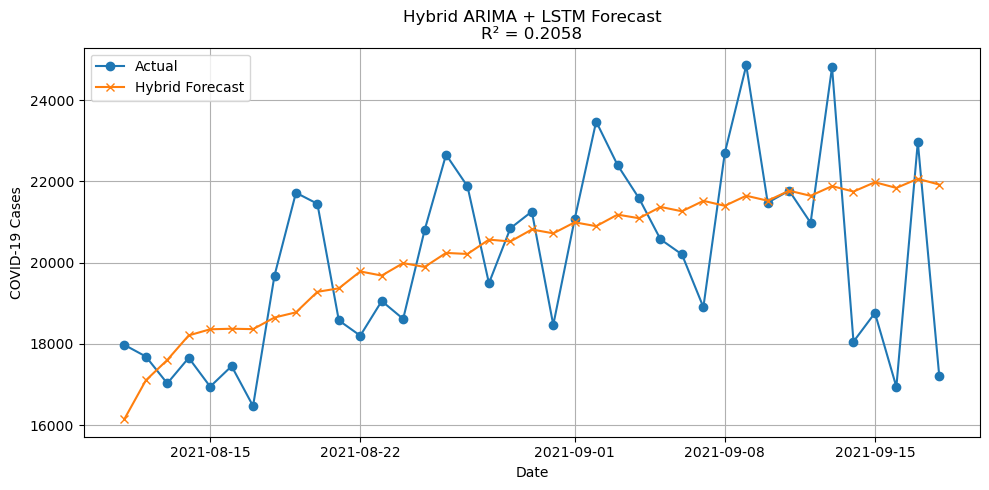

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# === Step 1: Load and prepare data ===
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

target_col = 'Recoveries COVID-19 Cases'
ts = data.set_index('Date')[target_col]

# === Step 2: Train/test split ===
train_ts = ts[:'2021-08-10']
test_ts = ts['2021-08-11':'2021-09-18']

# === Step 3: Fit best ARIMA model ===
best_order = (8, 1, 2)  # Use your best found (p,d,q) here
arima_model = ARIMA(train_ts, order=best_order).fit()

# === Step 4: Forecast on test set using ARIMA ===
arima_forecast = arima_model.forecast(steps=len(test_ts))
arima_forecast.index = test_ts.index

# === Step 5: Calculate residuals on training data ===
arima_pred_train = arima_model.predict(start=train_ts.index[1], end=train_ts.index[-1])
residuals = train_ts[1:] - arima_pred_train

# === Step 6: Scale residuals and create LSTM sequences ===
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i - seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_len = 10
x_lstm, y_lstm = create_sequences(residuals_scaled, seq_len)

# === Step 7: Build and train LSTM ===
model = Sequential()
model.add(LSTM(64, input_shape=(seq_len, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_lstm, y_lstm, epochs=200, batch_size=16, verbose=1)

# === Step 8: Predict residuals on test set ===
resid_history = residuals_scaled[-seq_len:].flatten().tolist()
lstm_pred_scaled = []

for _ in range(len(test_ts)):
    input_seq = np.array(resid_history[-seq_len:]).reshape(1, seq_len, 1)
    pred = model.predict(input_seq, verbose=0)[0][0]
    lstm_pred_scaled.append(pred)
    resid_history.append(pred)

lstm_pred_resid = scaler.inverse_transform(np.array(lstm_pred_scaled).reshape(-1, 1)).flatten()

# === Step 9: Final hybrid forecast ===
hybrid_forecast = arima_forecast.values + lstm_pred_resid

# === Step 10: Evaluate hybrid model ===
actual = test_ts.values
mse = mean_squared_error(actual, hybrid_forecast)
mae = mean_absolute_error(actual, hybrid_forecast)
mape = np.mean(np.abs((actual - hybrid_forecast) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, hybrid_forecast)

print("\n📊 Final Hybrid ARIMA + LSTM Forecast Evaluation:")
print(f"ARIMA Order Used: {best_order}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# === Plot actual vs hybrid forecast ===
plt.figure(figsize=(10, 5))
plt.plot(test_ts.index, actual, label='Actual', marker='o')
plt.plot(test_ts.index, hybrid_forecast, label='Hybrid Forecast', marker='x')
plt.title(f"Hybrid ARIMA + LSTM Forecast\nR² = {r2:.4f}")
plt.xlabel("Date")
plt.ylabel("COVID-19 Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
# === Extract hybrid forecast for 12/9/21 to 18/9/21 ===
forecast_range = pd.date_range(start='2021-09-12', end='2021-09-18')
hybrid_forecast_series = pd.Series(hybrid_forecast, index=test_ts.index)
selected_forecast = hybrid_forecast_series.loc[forecast_range]

# Print forecasted values for the selected range
print("\n📅 Hybrid Forecast: 12/09/2021 to 18/09/2021")
print(selected_forecast.round(0).astype(int))



📅 Hybrid Forecast: 12/09/2021 to 18/09/2021
2021-09-12    21644
2021-09-13    21883
2021-09-14    21749
2021-09-15    21978
2021-09-16    21838
2021-09-17    22063
2021-09-18    21921
dtype: int32


22:04:46 - cmdstanpy - INFO - Chain [1] start processing
22:04:46 - cmdstanpy - INFO - Chain [1] done processing



📊 Final Hybrid prophet + xgb Forecast Evaluation:
Mean Squared Error (MSE): 5973995.79
Mean Absolute Error (MAE): 2006.48
Mean Absolute Percentage Error (MAPE): 9.76%
Root Mean Squared Error (RMSE): 2444.18
Relative RMSE (RRMSE): 0.2914
Normalized RMSE (NRMSE): 0.1218
R-squared (R²): -0.1887


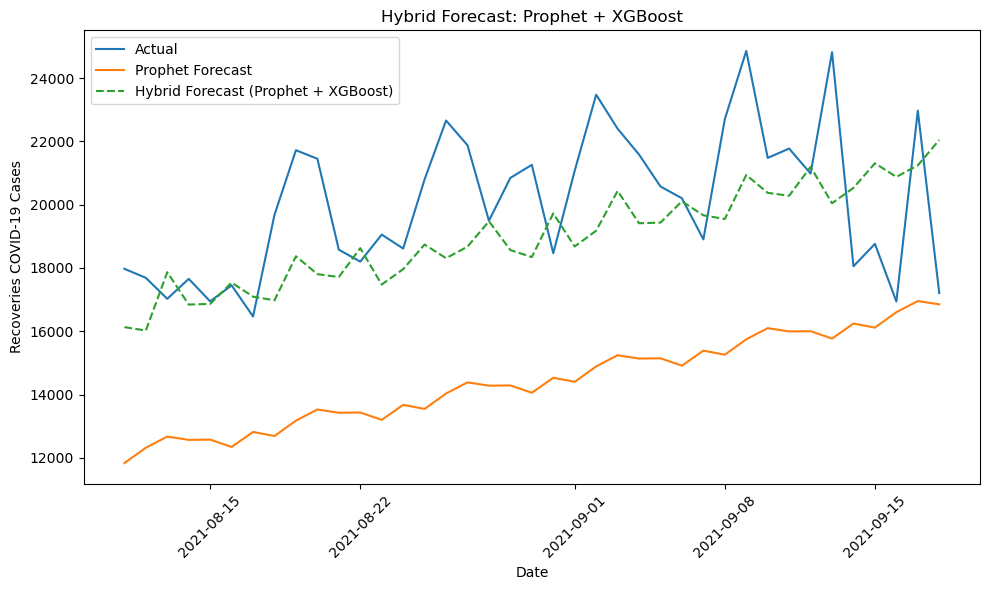


📈 Hybrid Prophet + XGBoost Forecast (12–18 Sept 2021):
         Date  Actual       Prophet  Hybrid_Forecast
32 2021-09-12   20980  16001.476461     21193.593648
33 2021-09-13   24813  15769.352766     20043.801984
34 2021-09-14   18053  16243.180048     20530.312373
35 2021-09-15   18760  16115.390425     21307.507612
36 2021-09-16   16939  16601.517610     20875.966829
37 2021-09-17   22970  16954.054236     21241.186560
38 2021-09-18   17205  16849.517337     22041.634525


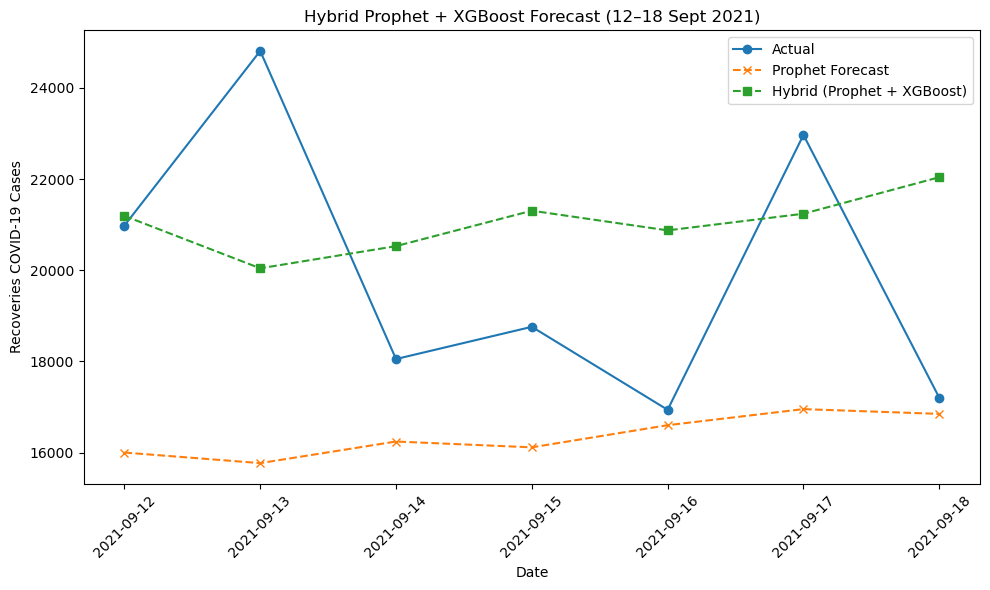

In [1]:
 import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# === Load your data ===
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data['Date'] = pd.to_datetime(data['Date'])
data = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

# === Prepare for Prophet ===
df_prophet = data[['Date', 'Recoveries COVID-19 Cases']].rename(columns={'Date': 'ds', 'Recoveries COVID-19 Cases': 'y'})

# === Split into train and test sets ===
train_end = '2021-08-10'
test_start = '2021-08-11'
test_end = '2021-09-18'

train_df = df_prophet[df_prophet['ds'] <= train_end].copy()
test_df = df_prophet[(df_prophet['ds'] >= test_start) & (df_prophet['ds'] <= test_end)].copy()

# === Step 1: Fit Prophet model ===
model = Prophet(daily_seasonality=True)
model.fit(train_df)

future = model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model.predict(future)

# === Step 2: Calculate residuals from training data ===
train_pred = forecast[['ds', 'yhat']].iloc[:len(train_df)].reset_index(drop=True)
train_df = train_df.reset_index(drop=True)
train_df['residual'] = train_df['y'] - train_pred['yhat']

# === Step 3: Create lag features for XGBoost ===
lags = 3
for i in range(1, lags + 1):
    train_df[f'lag{i}'] = train_df['residual'].shift(i)

train_df.dropna(inplace=True)

X_train = train_df[[f'lag{i}' for i in range(1, lags + 1)]]
y_train = train_df['residual']

# === Step 4: Train XGBoost on residuals ===
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(X_train, y_train)

# === Step 5: Predict residuals for test period ===
last_known = train_df[['residual'] + [f'lag{i}' for i in range(1, lags + 1)]].iloc[-1]
lag_values = [last_known[f'lag{i}'] for i in range(1, lags + 1)]
predicted_residuals = []

for _ in range(len(test_df)):
    x_input = np.array(lag_values).reshape(1, -1)
    pred_resid = model_xgb.predict(x_input)[0]
    predicted_residuals.append(pred_resid)

    # update lag values
    lag_values = lag_values[1:] + [pred_resid]

# === Step 6: Combine with Prophet forecast ===
prophet_forecast = forecast['yhat'].iloc[-len(test_df):].values
hybrid_forecast = prophet_forecast + np.array(predicted_residuals)
actual = test_df['y'].values

# === Step 7: Evaluation ===
mse = mean_squared_error(actual, hybrid_forecast)
mae = mean_absolute_error(actual, hybrid_forecast)
mape = np.mean(np.abs((actual - hybrid_forecast) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, hybrid_forecast)

print("\n📊 Final Hybrid prophet + xgb Forecast Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# === Step 8: Plot results ===
plt.figure(figsize=(10, 6))
plt.plot(test_df['ds'], actual, label='Actual')
plt.plot(test_df['ds'], prophet_forecast, label='Prophet Forecast')
plt.plot(test_df['ds'], hybrid_forecast, label='Hybrid Forecast (Prophet + XGBoost)', linestyle='--')
plt.title('Hybrid Forecast: Prophet + XGBoost')
plt.xlabel('Date')
plt.ylabel('Recoveries COVID-19 Cases')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
# === Step 9: Extract forecast for 12–18 Sept 2021 ===
forecast_horizon = pd.date_range(start="2021-09-12", end="2021-09-18")

results_df = pd.DataFrame({
    "Date": test_df['ds'].values,
    "Actual": actual,
    "Prophet": prophet_forecast,
    "Hybrid_Forecast": hybrid_forecast
})

# Filter only 12–18 Sept 2021
results_subset = results_df[results_df["Date"].isin(forecast_horizon)]

print("\n📈 Hybrid Prophet + XGBoost Forecast (12–18 Sept 2021):")
print(results_subset)

# === Plot only 12–18 Sept 2021 ===
plt.figure(figsize=(10, 6))
plt.plot(results_subset["Date"], results_subset["Actual"], marker='o', label="Actual")
plt.plot(results_subset["Date"], results_subset["Prophet"], marker='x', linestyle="--", label="Prophet Forecast")
plt.plot(results_subset["Date"], results_subset["Hybrid_Forecast"], marker='s', linestyle="--", label="Hybrid (Prophet + XGBoost)")
plt.title("Hybrid Prophet + XGBoost Forecast (12–18 Sept 2021)")
plt.xlabel("Date")
plt.ylabel("Recoveries COVID-19 Cases")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ================================
# 1. Load and prepare the dataset
# ================================
df = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")

# Ensure proper column names
df.rename(columns={"Date": "ds", "Recoveries COVID-19 Cases": "y"}, inplace=True)

# Sort by date
df['ds'] = pd.to_datetime(df['ds'])
df = df.sort_values("ds")

# ================================
# 2. Train/Validation/Test Split
# ================================
train = df[(df['ds'] >= "2021-01-04") & (df['ds'] <= "2021-07-02")]
val   = df[(df['ds'] >= "2021-07-03") & (df['ds'] <= "2021-08-10")]
test  = df[(df['ds'] >= "2021-08-11") & (df['ds'] <= "2021-09-18")]

# Target variable
y_train = train['y']
y_val = val['y']
y_test = test['y']

# ================================
# 3. ARIMA Model
# ================================
arima_model = ARIMA(y_train, order=(8,1,2))  # you can tune p,d,q
arima_fit = arima_model.fit()

# Forecast including validation + test
arima_forecast = arima_fit.predict(start=len(y_train), end=len(y_train)+len(y_val)+len(y_test)-1)

# ================================
# 4. Prophet Model
# ================================
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(train)

future = prophet_model.make_future_dataframe(periods=len(val)+len(test))
prophet_forecast = prophet_model.predict(future)
prophet_pred = prophet_forecast.iloc[-(len(val)+len(test)):, :]["yhat"].values

# ================================
# 5. Hybrid Forecast (Average)
# ================================
hybrid_forecast = (arima_forecast.values + prophet_pred) / 2

# Align with actual test data
actual = pd.concat([y_val, y_test]).reset_index(drop=True)
preds = pd.Series(hybrid_forecast, index=actual.index)

# ================================
# 6. Error Metrics
# ================================
mse = mean_squared_error(actual, hybrid_forecast)
mae = mean_absolute_error(actual, hybrid_forecast)
mape = np.mean(np.abs((actual - hybrid_forecast) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, hybrid_forecast)

print("\n📊 Final Hybrid ARIMA + Prophet Forecast Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
# ================================
# 7. Predict for 12/9/21 → 18/9/21
# ================================
future_dates = pd.date_range("2021-09-12", "2021-09-18")

# ARIMA rolling forecast for test set
arima_pred_test = arima_fit.predict(start=len(y_train)+len(y_val), end=len(y_train)+len(y_val)+len(y_test)-1)

# Prophet forecast already includes full range
prophet_test_pred = prophet_pred[-len(y_test):]

# Hybrid for test period
hybrid_test_pred = (arima_pred_test.values + prophet_test_pred) / 2

# Match only 12–18 Sep 2021
forecast_df = pd.DataFrame({
    "Date": test['ds'].values,
    "Actual": test['y'].values,
    "ARIMA_Pred": arima_pred_test.values,
    "Prophet_Pred": prophet_test_pred,
    "Hybrid_Pred": hybrid_test_pred
})

forecast_df = forecast_df[(forecast_df["Date"] >= "2021-09-12") & (forecast_df["Date"] <= "2021-09-18")]
print("\nForecast (12/09/2021 → 18/09/2021):")
print(forecast_df)


22:07:01 - cmdstanpy - INFO - Chain [1] start processing
22:07:01 - cmdstanpy - INFO - Chain [1] done processing



📊 Final Hybrid ARIMA + Prophet Forecast Evaluation:
Mean Squared Error (MSE): 81319375.86
Mean Absolute Error (MAE): 7498.15
Mean Absolute Percentage Error (MAPE): 43.53%
Root Mean Squared Error (RMSE): 9017.73
Relative RMSE (RRMSE): 0.4437
Normalized RMSE (NRMSE): 0.6138
R-squared (R²): -1.0998

Forecast (12/09/2021 → 18/09/2021):
         Date  Actual   ARIMA_Pred  Prophet_Pred  Hybrid_Pred
32 2021-09-12   20980  5803.839991  11494.382767  8649.111379
33 2021-09-13   24813  5803.839972  11233.954181  8518.897077
34 2021-09-14   18053  5803.839986  11524.206062  8664.023024
35 2021-09-15   18760  5803.840012  11403.196793  8603.518403
36 2021-09-16   16939  5803.840030  11811.190125  8807.515077
37 2021-09-17   22970  5803.840031  12021.050964  8912.445498
38 2021-09-18   17205  5803.840021  11933.809462  8868.824742


E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Epoch 1/50


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2694
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0287
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0238
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0260
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0178
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0257 
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0233
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0214
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0244
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0246 
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0239
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0231
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0224
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0195
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0229
Epoch 16/50
13/13 ━━━━━━━━━━

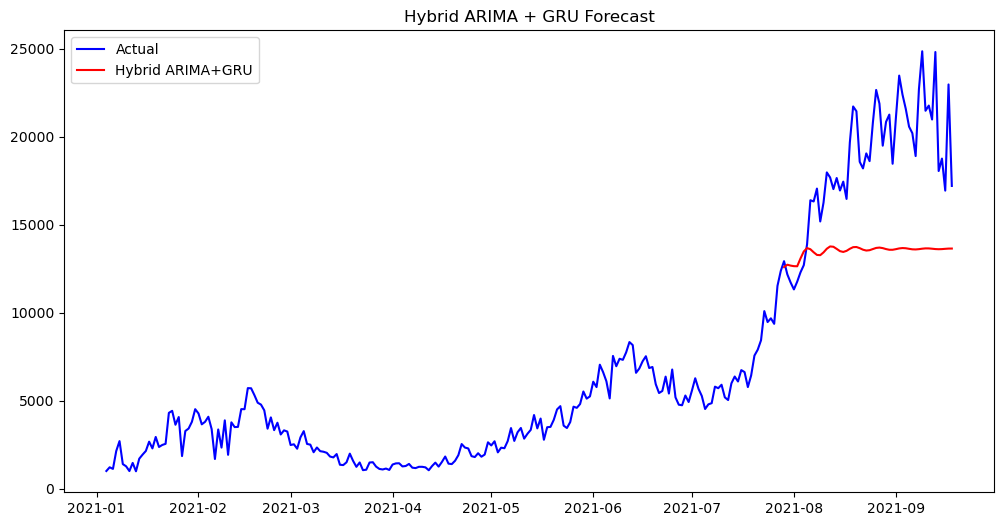


📌 Forecast (12/09/2021 → 18/09/2021):
         Date   Actual   Hybrid_Pred
45 2021-09-12  20980.0  13638.140087
46 2021-09-13  24813.0  13618.573825
47 2021-09-14  18053.0  13609.936908
48 2021-09-15  18760.0  13616.540401
49 2021-09-16  16939.0  13632.105171
50 2021-09-17  22970.0  13645.241781
51 2021-09-18  17205.0  13647.603361


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam

# -------------------------------
# 1. Load your data
# -------------------------------
df = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

series = df['Recoveries COVID-19 Cases'].astype(float)

# -------------------------------
# 2. Train-Test Split
# -------------------------------
train_size = int(len(series) * 0.8)
train, test = series.iloc[:train_size], series.iloc[train_size:]

# -------------------------------
# 3. Fit ARIMA model
# -------------------------------
arima_order = (8, 1, 2)   # can be tuned
arima_model = ARIMA(train, order=arima_order)
arima_fit = arima_model.fit()

# Predict with ARIMA
arima_pred = arima_fit.predict(start=len(train), end=len(train)+len(test)-1)

# -------------------------------
# 4. Compute residuals
# -------------------------------
residuals = train - arima_fit.fittedvalues
residuals = residuals.dropna()

# -------------------------------
# 5. Prepare residuals for GRU
# -------------------------------
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals.values.reshape(-1, 1))

def create_sequences(data, timesteps=5):
    X, y = [], []
    for i in range(len(data)-timesteps):
        X.append(data[i:i+timesteps])
        y.append(data[i+timesteps])
    return np.array(X), np.array(y)

timesteps = 5
X, y = create_sequences(residuals_scaled, timesteps)
X = X.reshape((X.shape[0], X.shape[1], 1))

# -------------------------------
# 6. Build GRU model
# -------------------------------
gru_model = Sequential([
    GRU(64, input_shape=(timesteps,1), return_sequences=False),
    Dense(1)
])
gru_model.compile(optimizer=Adam(0.001), loss='mse')

gru_model.fit(X, y, epochs=50, batch_size=16, verbose=1)

# -------------------------------
# 7. Forecast residuals with GRU
# -------------------------------
test_residuals = []
last_sequence = residuals_scaled[-timesteps:]

for i in range(len(test)):
    seq_input = last_sequence.reshape((1, timesteps, 1))
    pred_res = gru_model.predict(seq_input, verbose=0)
    test_residuals.append(pred_res[0,0])
    last_sequence = np.append(last_sequence[1:], pred_res[0,0])
    
test_residuals = scaler.inverse_transform(np.array(test_residuals).reshape(-1,1)).flatten()

# -------------------------------
# 8. Hybrid Forecast
# -------------------------------
hybrid_pred = arima_pred.values + test_residuals

# -------------------------------
# 9. Evaluation
# -------------------------------
actual = test.values
hybrid_forecast = hybrid_pred

mse = mean_squared_error(actual, hybrid_forecast)
mae = mean_absolute_error(actual, hybrid_forecast)
mape = np.mean(np.abs((actual - hybrid_forecast) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, hybrid_forecast)

print("\n📊 Final Hybrid ARIMA + GRU Forecast Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
# -------------------------------
# 10. Visualization
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(series.index, series, label="Actual", color='blue')
plt.plot(test.index, hybrid_pred, label="Hybrid ARIMA+GRU", color='red')
plt.legend()
plt.title("Hybrid ARIMA + GRU Forecast")
plt.show()

# -------------------------------
# 11. Forecast for 12/09/2021 → 18/09/2021
# -------------------------------
# 11. Forecast for 12/09/2021 → 18/09/2021
# -------------------------------
# -------------------------------
# 11. Forecast for 12/09/2021 → 18/09/2021
# -------------------------------
forecast_df = pd.DataFrame({
    "Date": test.index,
    "Actual": test.values,
       # residual forecast (can be shown separately)
    "Hybrid_Pred": hybrid_pred      # ARIMA + GRU
}).reset_index(drop=True)

# Filter only 12–18 Sep 2021
forecast_df = forecast_df[(forecast_df["Date"] >= "2021-09-12") & (forecast_df["Date"] <= "2021-09-18")]

print("\n📌 Forecast (12/09/2021 → 18/09/2021):")
print(forecast_df)



E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
E:\anaconda\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.089e+05. Pa

                                   SARIMAX Results                                   
Dep. Variable:     Recoveries COVID-19 Cases   No. Observations:                  219
Model:                        ARIMA(8, 1, 2)   Log Likelihood               -1718.071
Date:                       Fri, 26 Sep 2025   AIC                           3458.142
Time:                               22:13:42   BIC                           3495.371
Sample:                           01-04-2021   HQIC                          3473.179
                                - 08-10-2021                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5230      0.111     -4.730      0.000      -0.740      -0.306
ar.L2          0.6332      0.147      4.308      0.000       0.345       0.

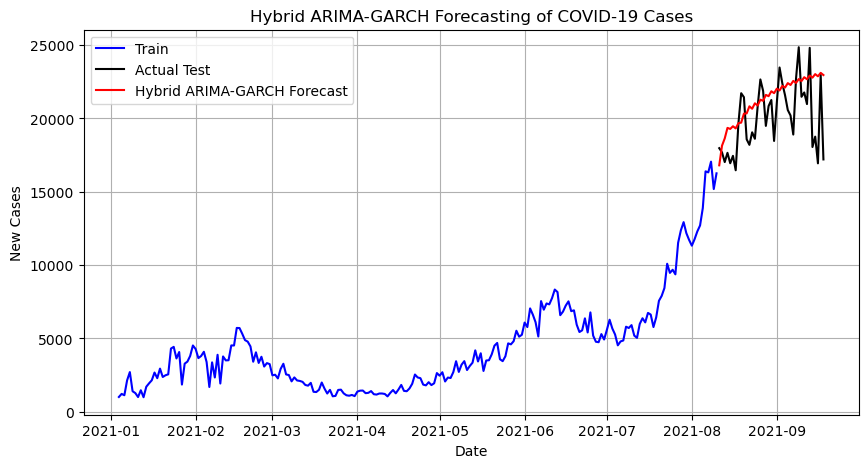

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ==============================
# Step 1: Load & preprocess data
# ==============================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx", 
                     parse_dates=['Date'], index_col='Date')

# Target time series
series = data['Recoveries COVID-19 Cases']

# Train-test split
train = series['2021-01-04':'2021-08-10']
test = series['2021-08-11':'2021-09-18']

# ==============================
# Step 2: Fit ARIMA model
# ==============================
arima_model = ARIMA(train, order=(8,1,2))
arima_fit = arima_model.fit()
print(arima_fit.summary())

# Residuals
residuals = arima_fit.resid

# ==============================
# Step 3: Fit GARCH on residuals
# ==============================
garch = arch_model(residuals, vol='GARCH', p=8, q=2)
garch_fit = garch.fit(disp="off")
print(garch_fit.summary())

# ==============================
# Step 4: Forecast
# ==============================
# ARIMA forecast
arima_forecast = arima_fit.forecast(steps=len(test))

# GARCH forecast (step-wise volatility)
garch_forecast = garch_fit.forecast(horizon=len(test))
garch_vol_series = np.sqrt(garch_forecast.variance.values[-1, :])  # std dev for each step

# Hybrid forecast = ARIMA forecast + volatility adjustment
hybrid_forecast = arima_forecast + garch_vol_series
hybrid_forecast = pd.Series(hybrid_forecast, index=test.index)

# ==============================
# Step 5: Evaluation
# ==============================
actual = test  # define actual values

mse = mean_squared_error(actual, hybrid_forecast)
mae = mean_absolute_error(actual, hybrid_forecast)
mape = np.mean(np.abs((actual - hybrid_forecast) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, hybrid_forecast)

print("\n📊 Final Hybrid ARIMA-GARCH Forecast Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

# ==============================
# Step 6: Plot
# ==============================
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label="Train", color="blue")
plt.plot(test.index, test, label="Actual Test", color="black")
plt.plot(hybrid_forecast.index, hybrid_forecast, 
         label="Hybrid ARIMA-GARCH Forecast", color="red")

plt.title("Hybrid ARIMA-GARCH Forecasting of COVID-19 Cases")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.legend()
plt.grid(True)
plt.show()


Hybrid ARIMA-GARCH Forecast (12–18 Sept 2021):
Date
2021-09-12    49144.644678
2021-09-13    50713.848874
2021-09-14    52022.256072
2021-09-15    53635.262360
2021-09-16    54995.977661
2021-09-17    56697.501428
2021-09-18    58127.344652
Name: predicted_mean, dtype: float64


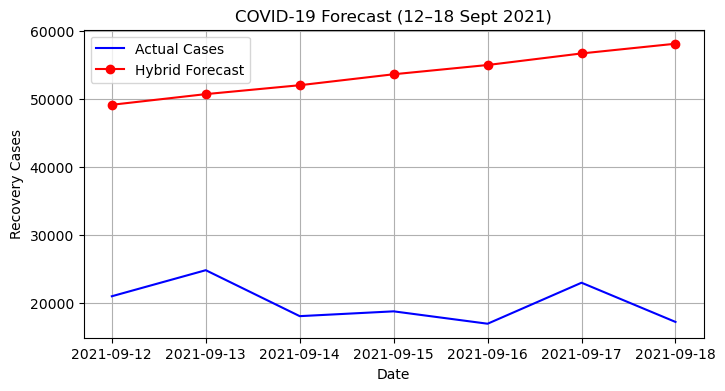

In [7]:
# Select forecast window
forecast_window = hybrid_forecast['2021-09-12':'2021-09-18']
actual_window = test['2021-09-12':'2021-09-18']

print("Hybrid ARIMA-GARCH Forecast (12–18 Sept 2021):")
print(forecast_window)

# Plot actual vs forecast for just that window
plt.figure(figsize=(8,4))
plt.plot(actual_window.index, actual_window, label="Actual Cases", color="blue")
plt.plot(forecast_window.index, forecast_window, label="Hybrid Forecast", color="red", marker='o')

plt.title("COVID-19 Forecast (12–18 Sept 2021)")
plt.xlabel("Date")
plt.ylabel("Recovery Cases")
plt.legend()
plt.grid(True)
plt.show()


E:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Hybrid ARIMA-XGBoost Forecast Evaluation:
Mean Squared Error (MSE): 3723099.97
Mean Absolute Error (MAE): 1536.60
Mean Absolute Percentage Error (MAPE): 7.87%
Root Mean Squared Error (RMSE): 1929.53
Relative RMSE (RRMSE): 0.2300
Normalized RMSE (NRMSE): 0.0962
R-squared (R²): 0.2592


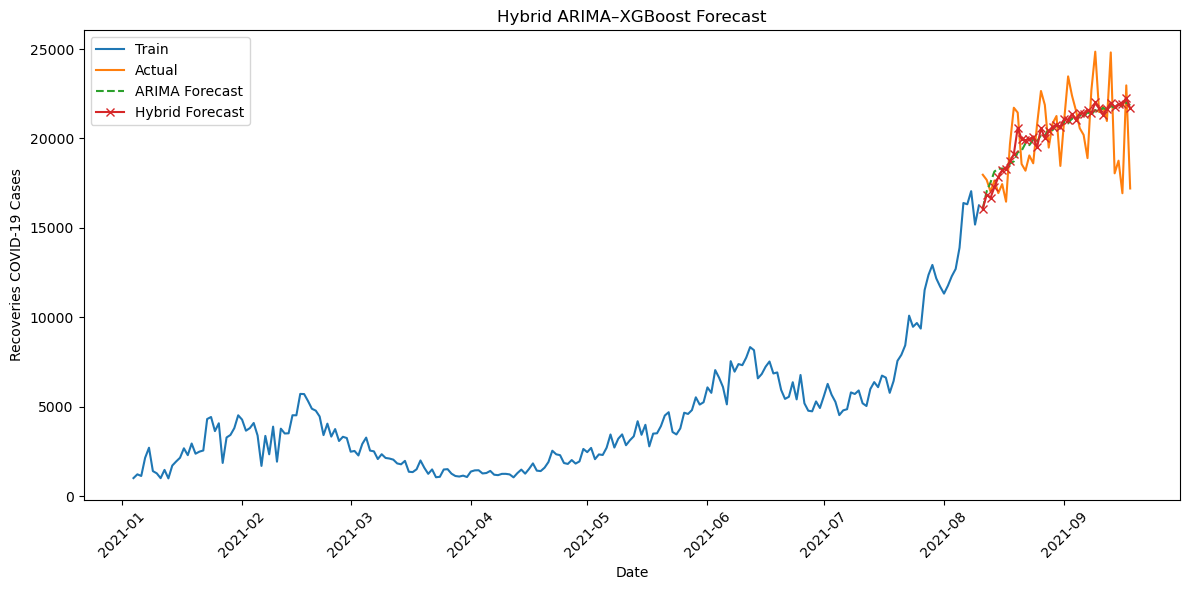


📌 Hybrid ARIMA–XGBoost Forecast (12–18 Sept 2021):
          Date  Actual  ARIMA_Forecast  Hybrid_Forecast
251 2021-09-12   20980    21591.375997     21660.197149
252 2021-09-13   24813    21830.000892     22006.957008
253 2021-09-14   18053    21696.055504     21760.974762
254 2021-09-15   18760    21925.214589     21913.353894
255 2021-09-16   16939    21785.368474     21944.469701
256 2021-09-17   22970    22009.773930     22281.758976
257 2021-09-18   17205    21867.717063     21680.940330


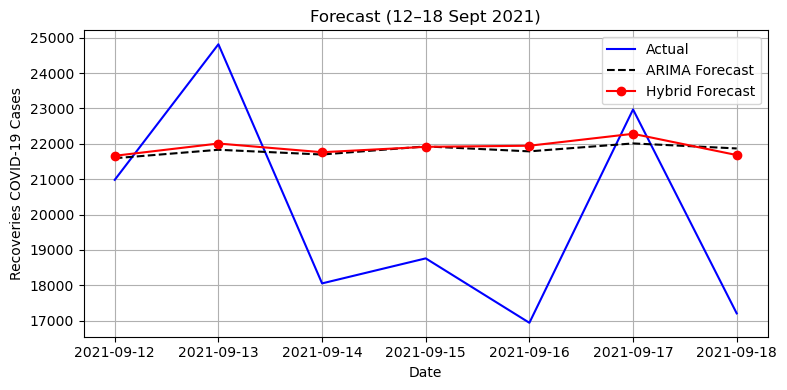

In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === Load your data ===
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data = data.rename(columns={'Recoveries COVID-19 Cases': 'y'})
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date').reset_index(drop=True)

# === Train/Validation/Test split ===
train_end = '2021-08-10'
test_start = '2021-08-11'
test_end = '2021-09-18'

train_data = data[(data['Date'] <= train_end)]
test_data = data[(data['Date'] >= test_start) & (data['Date'] <= test_end)]

# === Step 1: ARIMA model ===
arima_model = ARIMA(train_data['y'], order=(8,1,2))  # adjust (p,d,q)
arima_fit = arima_model.fit()

# Forecast ARIMA on test period
arima_forecast = arima_fit.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, dynamic=False)

# Compute residuals (train)
arima_fitted = arima_fit.fittedvalues
residuals = train_data['y'] - arima_fitted

# === Step 2: Train XGBoost on residuals ===
# Create lag features
def create_lags(series, lags=[1,2,3,7,14]):
    df = pd.DataFrame({'resid': series})
    for lag in lags:
        df[f'lag_{lag}'] = df['resid'].shift(lag)
    return df.dropna()

lags = [1,2,3,7,14]
resid_lags = create_lags(residuals, lags=lags)

X_resid = resid_lags.drop('resid', axis=1)
y_resid = resid_lags['resid']

# Train XGBoost
xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb.fit(X_resid, y_resid)

# === Step 3: Forecast residuals on test set ===
# Build lagged residuals from ARIMA forecast errors (recursive prediction)
test_resid_preds = []
prev_resids = list(residuals[-max(lags):])  # last known residuals

for _ in range(len(test_data)):
    # Build input vector
    input_feats = [prev_resids[-lag] for lag in lags]
    input_df = pd.DataFrame([input_feats], columns=[f'lag_{lag}' for lag in lags])
    
    # Predict next residual
    next_resid = xgb.predict(input_df)[0]
    test_resid_preds.append(next_resid)
    
    # Append for recursive usage
    prev_resids.append(next_resid)

# === Step 4: Hybrid Forecast ===
hybrid_forecast = arima_forecast.values + np.array(test_resid_preds)

# === Evaluation ===
# === Evaluation (Hybrid Forecast vs Actual) ===
y_true = test_data['y'].values
forecast = hybrid_forecast  # rename for clarity

mse = mean_squared_error(y_true, forecast)
mae = mean_absolute_error(y_true, forecast)
mape = np.mean(np.abs((y_true - forecast) / y_true)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(y_true) - np.min(y_true))   # relative to range
nrmse = rmse / np.mean(y_true)                     # relative to mean
r2 = r2_score(y_true, forecast)

# Print results
print("\nHybrid ARIMA-XGBoost Forecast Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Relative RMSE (RRMSE): {rrmse:.4f}")
print(f"Normalized RMSE (NRMSE): {nrmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


# === Plot Actual vs Forecast ===
plt.figure(figsize=(12,6))
plt.plot(train_data['Date'], train_data['y'], label="Train")
plt.plot(test_data['Date'], y_true, label="Actual")
plt.plot(test_data['Date'], arima_forecast, label="ARIMA Forecast", linestyle="--")
plt.plot(test_data['Date'], hybrid_forecast, label="Hybrid Forecast", marker='x')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Recoveries COVID-19 Cases")
plt.title("Hybrid ARIMA–XGBoost Forecast")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# ==============================
# Forecast window: 12/09/2021 → 18/09/2021
# ==============================
forecast_df = pd.DataFrame({
    "Date": test_data['Date'].values,
    "Actual": y_true,
    "ARIMA_Forecast": arima_forecast,
    "Hybrid_Forecast": hybrid_forecast
})

# Select only 12–18 Sept 2021
mask = (forecast_df['Date'] >= "2021-09-12") & (forecast_df['Date'] <= "2021-09-18")
forecast_window = forecast_df.loc[mask]

print("\n📌 Hybrid ARIMA–XGBoost Forecast (12–18 Sept 2021):")
print(forecast_window)

# Plot zoomed window
plt.figure(figsize=(8,4))
plt.plot(forecast_window['Date'], forecast_window['Actual'], label="Actual", color="blue")
plt.plot(forecast_window['Date'], forecast_window['ARIMA_Forecast'], 
         label="ARIMA Forecast", linestyle="--", color="black")
plt.plot(forecast_window['Date'], forecast_window['Hybrid_Forecast'], 
         label="Hybrid Forecast", marker="o", color="red")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Recoveries COVID-19 Cases")
plt.title("Forecast (12–18 Sept 2021)")
plt.grid(True)
plt.tight_layout()
plt.show()


E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
E:\anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Hybrid ARIMA–SVR Performance:
MSE: 3992596.19
MAE: 1585.18
MAPE: 8.09%
RMSE: 1998.15
RRMSE: 0.2382
NRMSE: 0.0996
R²: 0.2056


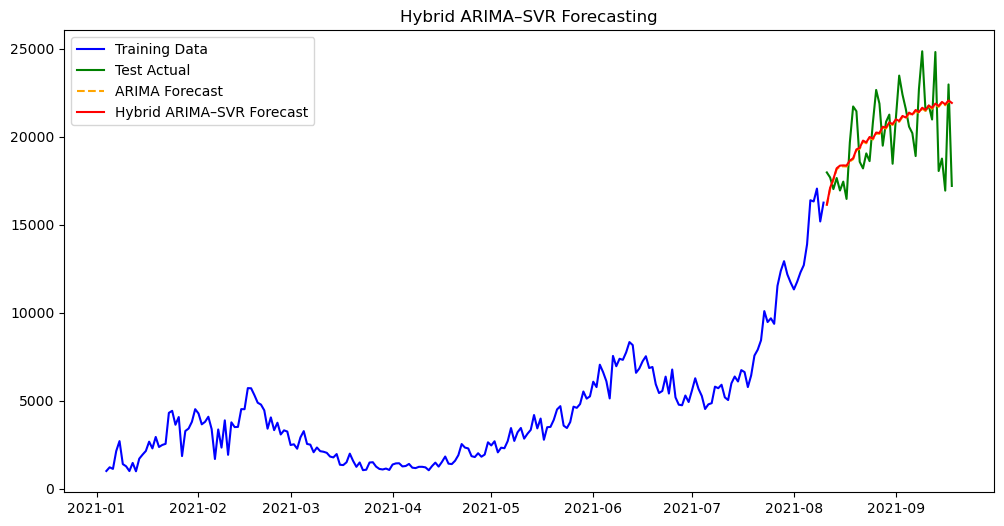

Hybrid ARIMA–SVR Forecast (12–18 Sept 2021):
2021-09-12    21644.406347
2021-09-13    21883.031242
2021-09-14    21749.085853
2021-09-15    21978.244938
2021-09-16    21838.398824
2021-09-17    22062.804280
2021-09-18    21920.747413
Freq: D, dtype: float64


In [9]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# === Step 1: Load and preprocess data ===
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data_filtered = data[(data['Date'] >= '2021-01-04') & (data['Date'] <= '2021-09-18')].reset_index(drop=True)

# Set time series
covid_cases_ts = data_filtered.set_index('Date')['Recoveries COVID-19 Cases']

# === Step 2: Train ARIMA model (linear component) ===
train_series = covid_cases_ts['2021-01-04':'2021-08-10']  # train+val
test_series = covid_cases_ts['2021-08-11':'2021-09-18']

arima_model = ARIMA(train_series, order=(8,1,2))  # Example order
arima_fit = arima_model.fit()

# In-sample fitted values
arima_fitted = arima_fit.fittedvalues
residuals = train_series - arima_fitted

# === Step 3: Prepare residuals for SVR (nonlinear component) ===
# Explicitly name the residuals column
residuals_df = pd.DataFrame(residuals, columns=["residuals"])

# Create lag features
for lag in range(1, 8):  # last 7 lags
    residuals_df[f"lag_{lag}"] = residuals_df["residuals"].shift(lag)

residuals_df = residuals_df.dropna()

# Features & target for SVR
X_res = residuals_df.drop(columns=["residuals"]).values
y_res = residuals_df["residuals"].values

# Scale features
scaler = MinMaxScaler()
X_res = scaler.fit_transform(X_res)

# Train SVR
svr_model = SVR(kernel="rbf", C=100, gamma=0.01, epsilon=50)
svr_model.fit(X_res, y_res)

# === Step 4: Forecast with ARIMA + SVR ===
arima_forecast = arima_fit.forecast(steps=len(test_series))

# Build SVR input for test period residual prediction
resid_values = residuals.tolist()
svr_preds = []

for i in range(len(test_series)):
    last_lags = np.array(resid_values[-7:]).reshape(1, -1)  # last 7 residuals
    last_lags_scaled = scaler.transform(last_lags)
    svr_pred = svr_model.predict(last_lags_scaled)[0]
    svr_preds.append(svr_pred)
    resid_values.append(svr_pred)  # update with predicted residual

svr_preds = pd.Series(svr_preds, index=test_series.index)

# Hybrid forecast = ARIMA forecast + SVR residual forecast
hybrid_forecast = arima_forecast + svr_preds

# === Step 5: Evaluate ===
mse = mean_squared_error(test_series, hybrid_forecast)
mae = mean_absolute_error(test_series, hybrid_forecast)
mape = np.mean(np.abs((test_series - hybrid_forecast) / test_series)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(test_series) - np.min(test_series))
nrmse = rmse / np.mean(test_series)
r2 = r2_score(test_series, hybrid_forecast)

print("Hybrid ARIMA–SVR Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")

# === Step 6: Plot results ===
plt.figure(figsize=(12,6))
plt.plot(train_series.index, train_series, label="Training Data", color="blue")
plt.plot(test_series.index, test_series, label="Test Actual", color="green")
plt.plot(test_series.index, arima_forecast, label="ARIMA Forecast", color="orange", linestyle="--")
plt.plot(test_series.index, hybrid_forecast, label="Hybrid ARIMA–SVR Forecast", color="red")
plt.legend()
plt.title("Hybrid ARIMA–SVR Forecasting")
plt.show()
# Extract forecasts from 12 Sept 2021 to 18 Sept 2021
forecast_period = hybrid_forecast['2021-09-12':'2021-09-18']
print("Hybrid ARIMA–SVR Forecast (12–18 Sept 2021):")
print(forecast_period)


21:55:07 - cmdstanpy - INFO - Chain [1] start processing
21:55:07 - cmdstanpy - INFO - Chain [1] done processing


Hybrid prophet–SVR Performance:
MSE: 21527513.61
MAE: 3776.47
MAPE: 17.71%
RMSE: 4639.78
RRMSE: 0.5531
NRMSE: 0.2312
R²: -3.2834

Hybrid Forecast (12–18 Sept 2021):
            ds      y  Hybrid_Forecast
251 2021-09-12  20980     14969.163012
252 2021-09-13  24813     14684.351736
253 2021-09-14  18053     15086.846137
254 2021-09-15  18760     15020.687253
255 2021-09-16  16939     15431.801408
256 2021-09-17  22970     15732.396340
257 2021-09-18  17205     15597.839083


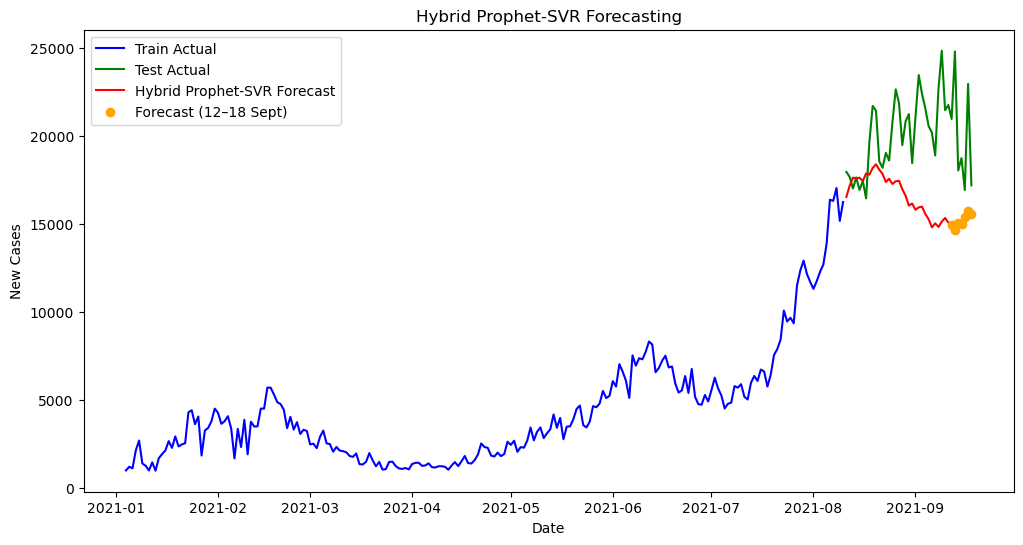

In [10]:
# =========================
# Prophet + SVR Hybrid Model with Forecasting for 12–18 Sept 2021
# =========================

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# =========================
# 1. Load and preprocess data
# =========================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")

# Rename columns to Prophet format
data["Date"] = pd.to_datetime(data["Date"])
data = data.rename(columns={"Date": "ds", "Recoveries COVID-19 Cases": "y"})

# =========================
# 2. Train/Test split
# =========================
train = data[data["ds"] <= "2021-08-10"]   # Train until Aug 10, 2021
test  = data[data["ds"] > "2021-08-10"]    # Test from Aug 11, 2021 onward

# =========================
# 3. Fit Prophet model
# =========================
prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet.fit(train)

# Forecast over the whole dataset length
future = prophet.make_future_dataframe(periods=len(test), freq="D")
prophet_forecast = prophet.predict(future)

# Align Prophet forecast with actual data
prophet_pred = prophet_forecast.set_index("ds").loc[data["ds"], "yhat"].values

# =========================
# 4. Compute residuals (Actual - Prophet)
# =========================
residuals = data["y"].values - prophet_pred
residuals_df = pd.DataFrame({"ds": data["ds"], "residuals": residuals})

# =========================
# 5. SVR on residuals
# =========================
# Create lag features for residuals (last 7 days)
for lag in range(1, 8):
    residuals_df[f"lag_{lag}"] = residuals_df["residuals"].shift(lag)

residuals_df = residuals_df.dropna().reset_index(drop=True)

# Train/Test split (same as before)
train_resid = residuals_df[residuals_df["ds"] <= "2021-08-10"]
test_resid  = residuals_df[residuals_df["ds"] > "2021-08-10"]

X_train = train_resid.drop(columns=["ds", "residuals"]).values
y_train = train_resid["residuals"].values
X_test  = test_resid.drop(columns=["ds", "residuals"]).values
y_test  = test_resid["residuals"].values

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Train SVR
svr = SVR(kernel="rbf", C=100, gamma=0.01, epsilon=50)
svr.fit(X_train, y_train)

# Predict residuals
resid_pred = svr.predict(X_test)

# =========================
# 6. Hybrid Forecast = Prophet + SVR residual correction
# =========================
hybrid_forecast = prophet_pred[-len(test):] + resid_pred

# =========================
# 7. Evaluation
# =========================
mse = mean_squared_error(test_series, hybrid_forecast)
mae = mean_absolute_error(test_series, hybrid_forecast)
mape = np.mean(np.abs((test_series - hybrid_forecast) / test_series)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(test_series) - np.min(test_series))
nrmse = rmse / np.mean(test_series)
r2 = r2_score(test_series, hybrid_forecast)

print("Hybrid prophet–SVR Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")

# =========================
# 8. Forecast for 12–18 Sept 2021
# =========================
forecast_week = test[(test["ds"] >= "2021-09-12") & (test["ds"] <= "2021-09-18")].copy()
forecast_week["Hybrid_Forecast"] = hybrid_forecast[-len(forecast_week):]

print("\nHybrid Forecast (12–18 Sept 2021):")
print(forecast_week[["ds", "y", "Hybrid_Forecast"]])

# =========================
# 9. Plot Results
# =========================
plt.figure(figsize=(12,6))
plt.plot(train["ds"], train["y"], label="Train Actual", color="blue")
plt.plot(test["ds"], test["y"], label="Test Actual", color="green")
plt.plot(test["ds"], hybrid_forecast, label="Hybrid Prophet-SVR Forecast", color="red")

# Highlight 12–18 Sept
plt.scatter(forecast_week["ds"], forecast_week["Hybrid_Forecast"], 
            color="orange", label="Forecast (12–18 Sept)", zorder=5)

plt.legend()
plt.title("Hybrid Prophet-SVR Forecasting")
plt.xlabel("Date")
plt.ylabel("New Cases")
plt.show()


21:56:32 - cmdstanpy - INFO - Chain [1] start processing
21:56:32 - cmdstanpy - INFO - Chain [1] done processing
E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.1231 - val_loss: 0.0142
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0155 - val_loss: 0.0066
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0048 - val_loss: 0.0061
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0047 - val_loss: 0.0069
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0037 - val_loss: 0.0060
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0038 - val_loss: 0.0060
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0039 - val_loss: 0.0060
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0035 - val_loss: 0.0057
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0038 - val_loss: 0.0058
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0039 - val_loss: 0.0056
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0

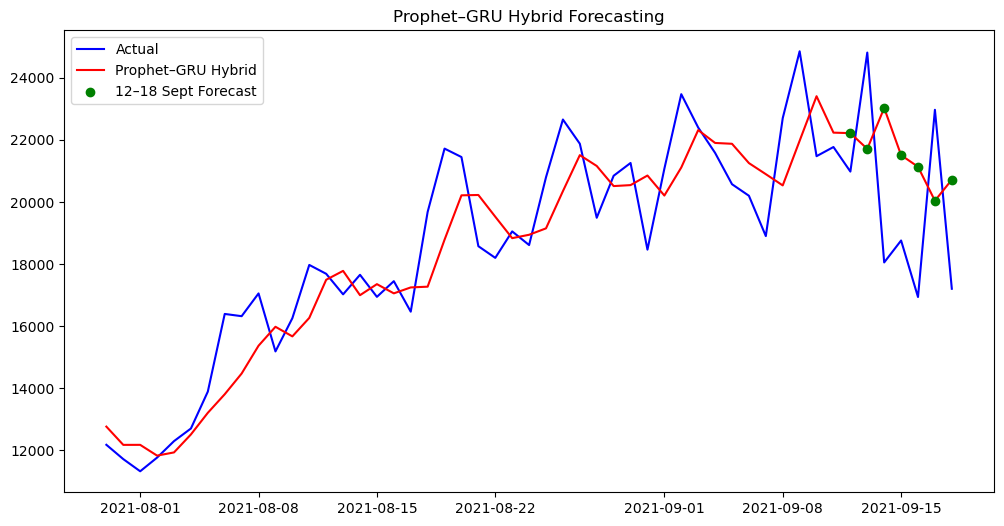

In [11]:
# =========================
# Prophet + GRU Hybrid Model
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =========================
# 1. Load data
# =========================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data["Date"] = pd.to_datetime(data["Date"])
data = data.rename(columns={"Date": "ds", "Recoveries COVID-19 Cases": "y"})

# =========================
# 2. Fit Prophet
# =========================
prophet = Prophet()
prophet.fit(data)

# Forecast with Prophet (in-sample)
future = prophet.make_future_dataframe(periods=0)
forecast = prophet.predict(future)

# Residuals = Actual - Prophet Prediction
data["prophet_pred"] = forecast["yhat"].values
data["residuals"] = data["y"] - data["prophet_pred"]

# =========================
# 3. Prepare GRU on residuals
# =========================
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(data["residuals"].values.reshape(-1,1))

def create_sequences(data, seq_length=7):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 7
X, y = create_sequences(residuals_scaled, seq_length)

# Split train/test (80/20)
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for GRU [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# =========================
# 4. Build GRU model
# =========================
gru_model = Sequential()
gru_model.add(GRU(64, activation="tanh", input_shape=(seq_length,1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer="adam", loss="mse")

# Train GRU
gru_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Predict residuals
residuals_pred_scaled = gru_model.predict(X_test)
residuals_pred = scaler.inverse_transform(residuals_pred_scaled)

# Align Prophet predictions with GRU predictions
prophet_test = data["prophet_pred"].values[-len(residuals_pred):].reshape(-1,1)
final_pred = prophet_test + residuals_pred

# Actual values
actual = data["y"].values[-len(residuals_pred):].reshape(-1,1)

# =========================
# 5. Evaluation
# =========================
mse = mean_squared_error(actual, final_pred)
mae = mean_absolute_error(actual, final_pred)
mape = np.mean(np.abs((actual - final_pred) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, final_pred)

print("Hybrid Prophet–GRU Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")

# =========================
# 6. Forecast extraction for 12–18 Sept 2021
# =========================
forecast_period = pd.DataFrame({
    "Date": data["ds"].values[-len(final_pred):],
    "Actual": actual.flatten(),
    "Hybrid_Forecast": final_pred.flatten()
})

week_forecast = forecast_period[
    (forecast_period["Date"] >= "2021-09-12") & 
    (forecast_period["Date"] <= "2021-09-18")
]

print("\nHybrid Prophet–GRU Forecast (12–18 Sept 2021):")
print(week_forecast)

# =========================
# 7. Plot results
# =========================
plt.figure(figsize=(12,6))
plt.plot(data["ds"].values[-len(actual):], actual, label="Actual", color="blue")
plt.plot(data["ds"].values[-len(actual):], final_pred, label="Prophet–GRU Hybrid", color="red")
plt.scatter(week_forecast["Date"], week_forecast["Hybrid_Forecast"], color="green", label="12–18 Sept Forecast", zorder=5)
plt.legend()
plt.title("Prophet–GRU Hybrid Forecasting")
plt.show()


Epoch 1/50


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.2003 - val_loss: 0.0413
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0521 - val_loss: 0.0404
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0510 - val_loss: 0.0296
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0372 - val_loss: 0.0243
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0318 - val_loss: 0.0242
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0344 - val_loss: 0.0260
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0353 - val_loss: 0.0263
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0300 - val_loss: 0.0246
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0363 - val_loss: 0.0242
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0357 - val_loss: 0.0249
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0322 - val_loss: 0.0246
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0344 - val_loss: 0.0247
Epoch 13/50


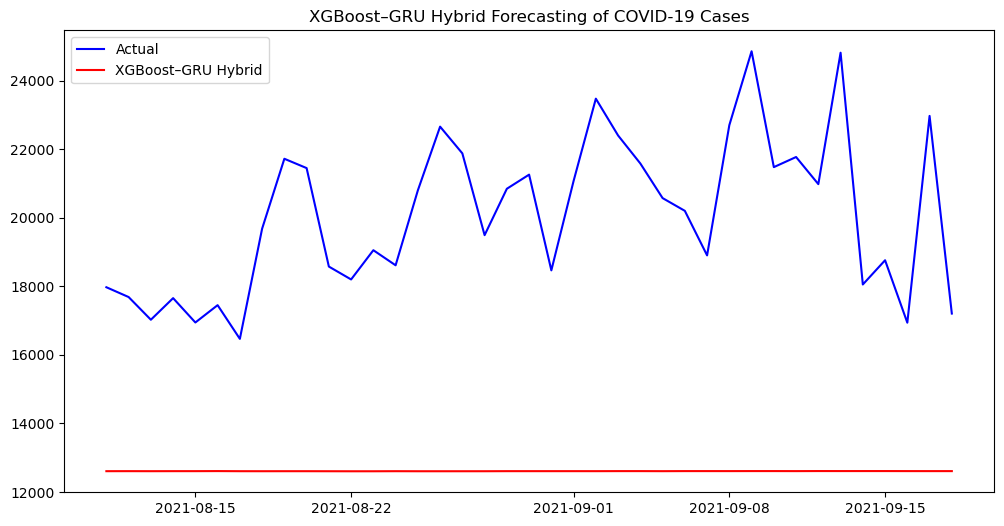


📌 Hybrid XGBoost–GRU Forecast (12–18 Sept 2021):
         Date  Actual  Hybrid_Forecast
32 2021-09-12   20980     12611.619141
33 2021-09-13   24813     12611.084961
34 2021-09-14   18053     12611.233398
35 2021-09-15   18760     12611.335938
36 2021-09-16   16939     12610.189453
37 2021-09-17   22970     12609.823242
38 2021-09-18   17205     12609.923828


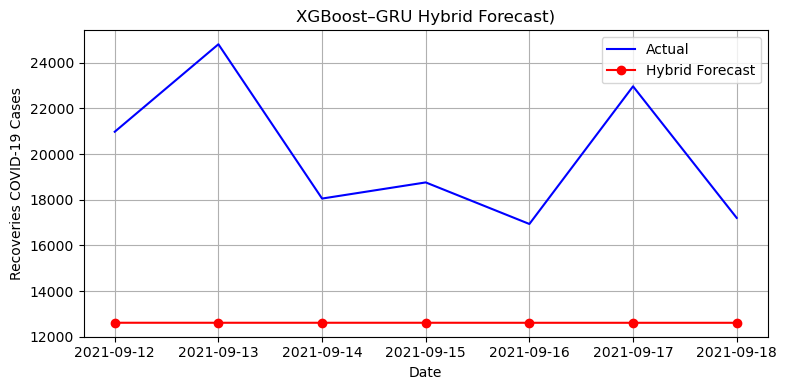

In [12]:
# =========================
# XGBoost + GRU Hybrid Model
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# =========================
# 1. Load data
# =========================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data["Date"] = pd.to_datetime(data["Date"])
data = data.rename(columns={"Date": "ds", "Recoveries COVID-19 Cases": "y"})

# =========================
# 2. Prepare features for XGBoost
# =========================
def create_lag_features(df, col="y", lags=7):
    for lag in range(1, lags+1):
        df[f"lag_{lag}"] = df[col].shift(lag)
    return df

data = create_lag_features(data, "y", lags=7)
data = data.dropna().reset_index(drop=True)

features = [col for col in data.columns if "lag_" in col]
X = data[features].values
y = data["y"].values

# Train/test split
split = int(len(data)*0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# =========================
# 3. Train XGBoost baseline
# =========================
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

# Train without early stopping (your version doesn’t support it)
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# XGBoost predictions
train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)

# Residuals
train_resid = y_train - train_pred
test_resid = y_test - test_pred

# =========================
# 4. GRU on residuals
# =========================
scaler = MinMaxScaler()
resid_scaled = scaler.fit_transform(train_resid.reshape(-1,1))

def create_sequences(data, seq_length=7):
    X_seq, y_seq = [], []
    for i in range(len(data)-seq_length):
        X_seq.append(data[i:i+seq_length])
        y_seq.append(data[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

seq_length = 7
X_seq, y_seq = create_sequences(resid_scaled, seq_length)

# Train/test split for GRU
split_gru = int(len(X_seq)*0.8)
X_train_seq, X_test_seq = X_seq[:split_gru], X_seq[split_gru:]
y_train_seq, y_test_seq = y_seq[:split_gru], y_seq[split_gru:]

# Reshape for GRU
X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], seq_length, 1))
X_test_seq  = X_test_seq.reshape((X_test_seq.shape[0], seq_length, 1))

# GRU model
gru_model = Sequential()
gru_model.add(GRU(64, activation="tanh", input_shape=(seq_length,1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer="adam", loss="mse")

# Train GRU
gru_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# Predict residuals
resid_pred_scaled = gru_model.predict(X_test_seq)
resid_pred = scaler.inverse_transform(resid_pred_scaled)

# Align lengths
xgb_test_pred = test_pred[-len(resid_pred):]
final_pred = xgb_test_pred + resid_pred.flatten()
actual = y_test[-len(resid_pred):]

# =========================
# 5. Evaluation
# =========================
mse = mean_squared_error(actual, final_pred)
mae = mean_absolute_error(actual, final_pred)
mape = np.mean(np.abs((actual - final_pred) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, final_pred)

print("Hybrid XGBoost–GRU Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")

# =========================
# 6. Plot results
# =========================
plt.figure(figsize=(12,6))
plt.plot(data["ds"].values[-len(actual):], actual, label="Actual", color="blue")
plt.plot(data["ds"].values[-len(final_pred):], final_pred, label="XGBoost–GRU Hybrid", color="red")
plt.legend()
plt.title("XGBoost–GRU Hybrid Forecasting of COVID-19 Cases")
plt.show()
# =========================
# 7. Forecast for 12/09/2021 → 18/09/2021
# =========================
forecast_df = pd.DataFrame({
    "Date": data["ds"].values[-len(actual):],
    "Actual": actual,
    "Hybrid_Forecast": final_pred
})

# Select only 12–18 Sept 2021
mask = (forecast_df["Date"] >= "2021-09-12") & (forecast_df["Date"] <= "2021-09-18")
forecast_window = forecast_df.loc[mask]

print("\n📌 Hybrid XGBoost–GRU Forecast (12–18 Sept 2021):")
print(forecast_window)

# Plot zoomed window
plt.figure(figsize=(8,4))
plt.plot(forecast_window["Date"], forecast_window["Actual"], label="Actual", color="blue")
plt.plot(forecast_window["Date"], forecast_window["Hybrid_Forecast"], 
         label="Hybrid Forecast", marker="o", color="red")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Recoveries COVID-19 Cases")
plt.title("XGBoost–GRU Hybrid Forecast)")
plt.grid(True)
plt.tight_layout()
plt.show()




📊 Hybrid XGBoost–SVR Performance:
MSE: 48243446.17
MAE: 6172.67
MAPE: 30.83%
RMSE: 6945.75
RRMSE: 0.5134
NRMSE: 0.3730
R²: -3.1399


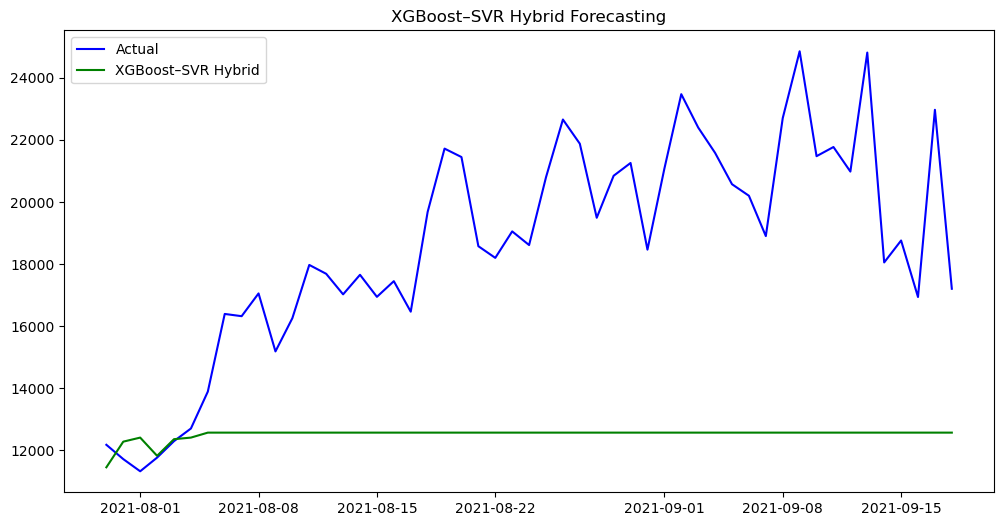

Hybrid XGBoost–SVR Forecast
          ds  Hybrid_XGB_SVR_Forecast
0 2021-09-12             12571.050957
1 2021-09-13             12571.050957
2 2021-09-14             12571.050957
3 2021-09-15             12571.050957
4 2021-09-16             12571.050957
5 2021-09-17             12571.050957
6 2021-09-18             12571.050957


In [4]:
# =========================
# XGBoost + SVR Hybrid Model
# =========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# =========================
# 1. Load data
# =========================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data["Date"] = pd.to_datetime(data["Date"])
data = data.rename(columns={"Date": "ds", "Recoveries COVID-19 Cases": "y"})

# =========================
# 2. Feature engineering (lags for supervised learning)
# =========================
df = data.copy()
for lag in range(1, 8):  # last 7 days as features
    df[f"lag_{lag}"] = df["y"].shift(lag)

df = df.dropna().reset_index(drop=True)

X = df[[f"lag_{i}" for i in range(1, 8)]].values
y = df["y"].values

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# =========================
# 3. Train XGBoost baseline
# =========================
xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predictions
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)

# Residuals
residuals_train = y_train - xgb_train_pred
residuals_test = y_test - xgb_test_pred

# =========================
# 4. Train SVR on residuals
# =========================
scaler = MinMaxScaler()
residuals_scaled = scaler.fit_transform(residuals_train.reshape(-1,1)).ravel()

svr = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train, residuals_scaled)

# SVR residual predictions (scaled back)
svr_resid_pred_scaled = svr.predict(X_test)
svr_resid_pred = scaler.inverse_transform(svr_resid_pred_scaled.reshape(-1,1)).ravel()

# =========================
# 5. Hybrid forecast = XGBoost + SVR residuals
# =========================
hybrid_pred = xgb_test_pred + svr_resid_pred

# =========================
# 6. Evaluation
# =========================
# =========================
# 6. Evaluation (fixed)
# =========================
actual = y_test
final_pred = hybrid_pred

mse = mean_squared_error(actual, final_pred)
mae = mean_absolute_error(actual, final_pred)
mape = np.mean(np.abs((actual - final_pred) / actual)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual) - np.min(actual))
nrmse = rmse / np.mean(actual)
r2 = r2_score(actual, final_pred)

print("\n📊 Hybrid XGBoost–SVR Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")


# =========================
# 7. Plot Results
# =========================
plt.figure(figsize=(12,6))
plt.plot(df["ds"].values[train_size:], y_test, label="Actual", color="blue")
plt.plot(df["ds"].values[train_size:], hybrid_pred, label="XGBoost–SVR Hybrid", color="green")
plt.legend()
plt.title("XGBoost–SVR Hybrid Forecasting")
plt.show()
# =========================
# Forecasting specific period: 12/09/2021 → 18/09/2021
# =========================

# Extract last known 7-day lag features **before 12 Sept 2021**
# Find the row corresponding to 11 Sept 2021
last_index = df[df['ds'] == '2021-09-11'].index[0]
last_known = df[[f"lag_{i}" for i in range(1, 8)]].iloc[last_index].values.reshape(1, -1)

forecast_dates = pd.date_range(start='2021-09-12', end='2021-09-18')
forecast_days = len(forecast_dates)

hybrid_forecast = []
current_input = last_known.copy()

for i in range(forecast_days):
    # XGBoost prediction
    xgb_pred = xgb_model.predict(current_input)[0]

    # SVR residual prediction
    svr_resid_scaled = svr.predict(current_input)[0]
    svr_resid = scaler.inverse_transform([[svr_resid_scaled]])[0][0]

    # Hybrid prediction
    hybrid_pred = xgb_pred + svr_resid
    hybrid_forecast.append(hybrid_pred)

    # Update input for next day (recursive)
    new_input = np.roll(current_input, -1)
    new_input[0, -1] = hybrid_pred
    current_input = new_input

# Put results into DataFrame
forecast_df = pd.DataFrame({
    "ds": forecast_dates,
    "Hybrid_XGB_SVR_Forecast": hybrid_forecast
})

print("Hybrid XGBoost–SVR Forecast")
print(forecast_df)


Epoch 1/50


E:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0187
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0015
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2514e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1906e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1572e-04
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.8370e-04
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.1649e-04
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.4396e-04
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.5929e-04
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0010
Epoch 15/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.1740e-

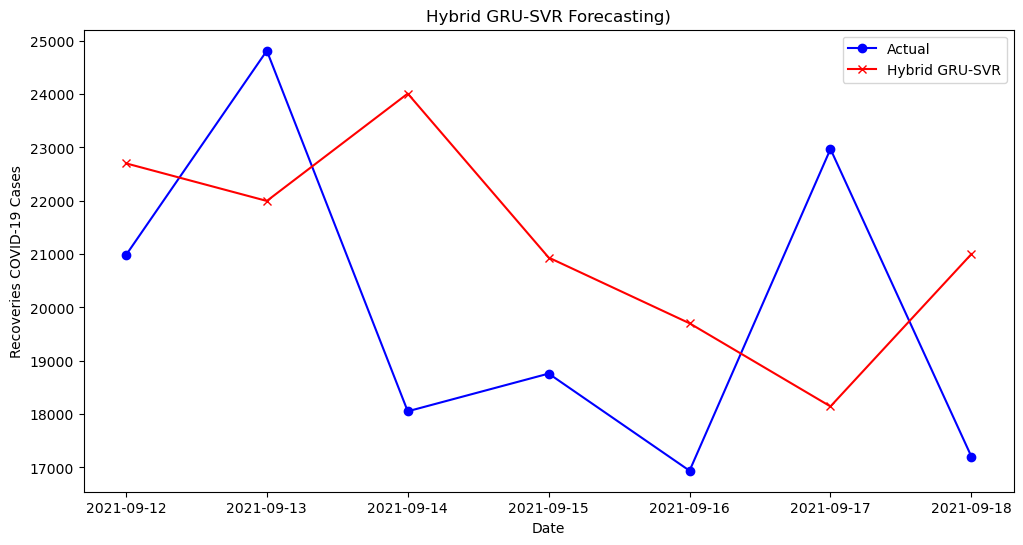

2021-09-12 - Predicted: 22701, Actual: 20980
2021-09-13 - Predicted: 21996, Actual: 24813
2021-09-14 - Predicted: 24009, Actual: 18053
2021-09-15 - Predicted: 20935, Actual: 18760
2021-09-16 - Predicted: 19702, Actual: 16939
2021-09-17 - Predicted: 18144, Actual: 22970
2021-09-18 - Predicted: 21000, Actual: 17205


In [7]:
# =========================
# GRU + SVR Hybrid Model (Forecast 12/09 → 18/09)
# =========================
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# =========================
# 1. Load data
# =========================
data = pd.read_excel("C:\\Users\\A B Siddik\\Desktop\\ARIMA\\data.xlsx")
data['Date'] = pd.to_datetime(data['Date'])
data = data.rename(columns={"Date": "ds", "Recoveries COVID-19 Cases": "y"})

# Normalize target for GRU
scaler = MinMaxScaler()
data['y_scaled'] = scaler.fit_transform(data[['y']])

# =========================
# 2. Prepare sequences for GRU
# =========================
def create_sequences(series, seq_length=7):
    X, y = [], []
    for i in range(len(series) - seq_length):
        X.append(series[i:i+seq_length])
        y.append(series[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 7
X, y = create_sequences(data['y_scaled'].values, seq_length)

# Train/test split
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape for GRU [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# =========================
# 3. Build and train GRU
# =========================
gru_model = Sequential()
gru_model.add(GRU(64, activation='tanh', input_shape=(seq_length,1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

# GRU predictions
gru_pred_scaled = gru_model.predict(X_test)
gru_pred = scaler.inverse_transform(gru_pred_scaled)

# =========================
# 4. Compute residuals and train SVR
# =========================
residuals = data['y'].values[-len(gru_pred):] - gru_pred.flatten()

# Create lag features for residuals
residuals_df = pd.DataFrame({'residuals': residuals})
for lag in range(1, 8):
    residuals_df[f'lag_{lag}'] = residuals_df['residuals'].shift(lag)
residuals_df = residuals_df.dropna()

X_resid = residuals_df[[f'lag_{i}' for i in range(1, 8)]].values
y_resid = residuals_df['residuals'].values

# Train/test split for SVR
split_idx = int(len(X_resid)*0.8)
X_svr_train, X_svr_test = X_resid[:split_idx], X_resid[split_idx:]
y_svr_train, y_svr_test = y_resid[:split_idx], y_resid[split_idx:]

# Train SVR
svr_model = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=50)
svr_model.fit(X_svr_train, y_svr_train)

# SVR residual predictions
resid_pred = svr_model.predict(X_svr_test)

# =========================
# 5. Hybrid Forecast = GRU + SVR residuals
# =========================
hybrid_forecast = gru_pred[-len(resid_pred):].flatten() + resid_pred

# =========================
# 6. Extract forecast for 12/09 → 18/09
# =========================
forecast_dates = pd.date_range(start='2021-09-12', end='2021-09-18')
# Ensure length matches
hybrid_7days = hybrid_forecast[-7:]
actual_7days = data[data['ds'].between('2021-09-12','2021-09-18')]['y'].values

# =========================
# 7. Evaluation
# =========================
# 7. Evaluation (Fix)
# =========================
mse = mean_squared_error(actual_7days, hybrid_7days)
mae = mean_absolute_error(actual_7days, hybrid_7days)
mape = np.mean(np.abs((actual_7days - hybrid_7days) / actual_7days)) * 100
rmse = np.sqrt(mse)
rrmse = rmse / (np.max(actual_7days) - np.min(actual_7days))
nrmse = rmse / np.mean(actual_7days)
r2 = r2_score(actual_7days, hybrid_7days)

print("Hybrid GRU-SVR Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"RMSE: {rmse:.2f}")
print(f"RRMSE: {rrmse:.4f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²: {r2:.4f}")


# =========================
# 8. Plot results
# =========================
plt.figure(figsize=(12,6))
plt.plot(forecast_dates, actual_7days, label='Actual', color='blue', marker='o')
plt.plot(forecast_dates, hybrid_7days, label='Hybrid GRU-SVR', color='red', marker='x')
plt.title('Hybrid GRU-SVR Forecasting)')
plt.xlabel('Date')
plt.ylabel('Recoveries COVID-19 Cases')
plt.legend()
plt.show()
# 6. Extract forecast for 12/09 → 18/09
# =========================
forecast_dates = pd.date_range(start='2021-09-12', end='2021-09-18')
# Ensure length matches
hybrid_7days = hybrid_forecast[-7:]
actual_7days = data[data['ds'].between('2021-09-12','2021-09-18')]['y'].values
for date, pred, actual in zip(forecast_dates, hybrid_7days, actual_7days):
    print(f"{date.date()} - Predicted: {int(pred)}, Actual: {int(actual)}")

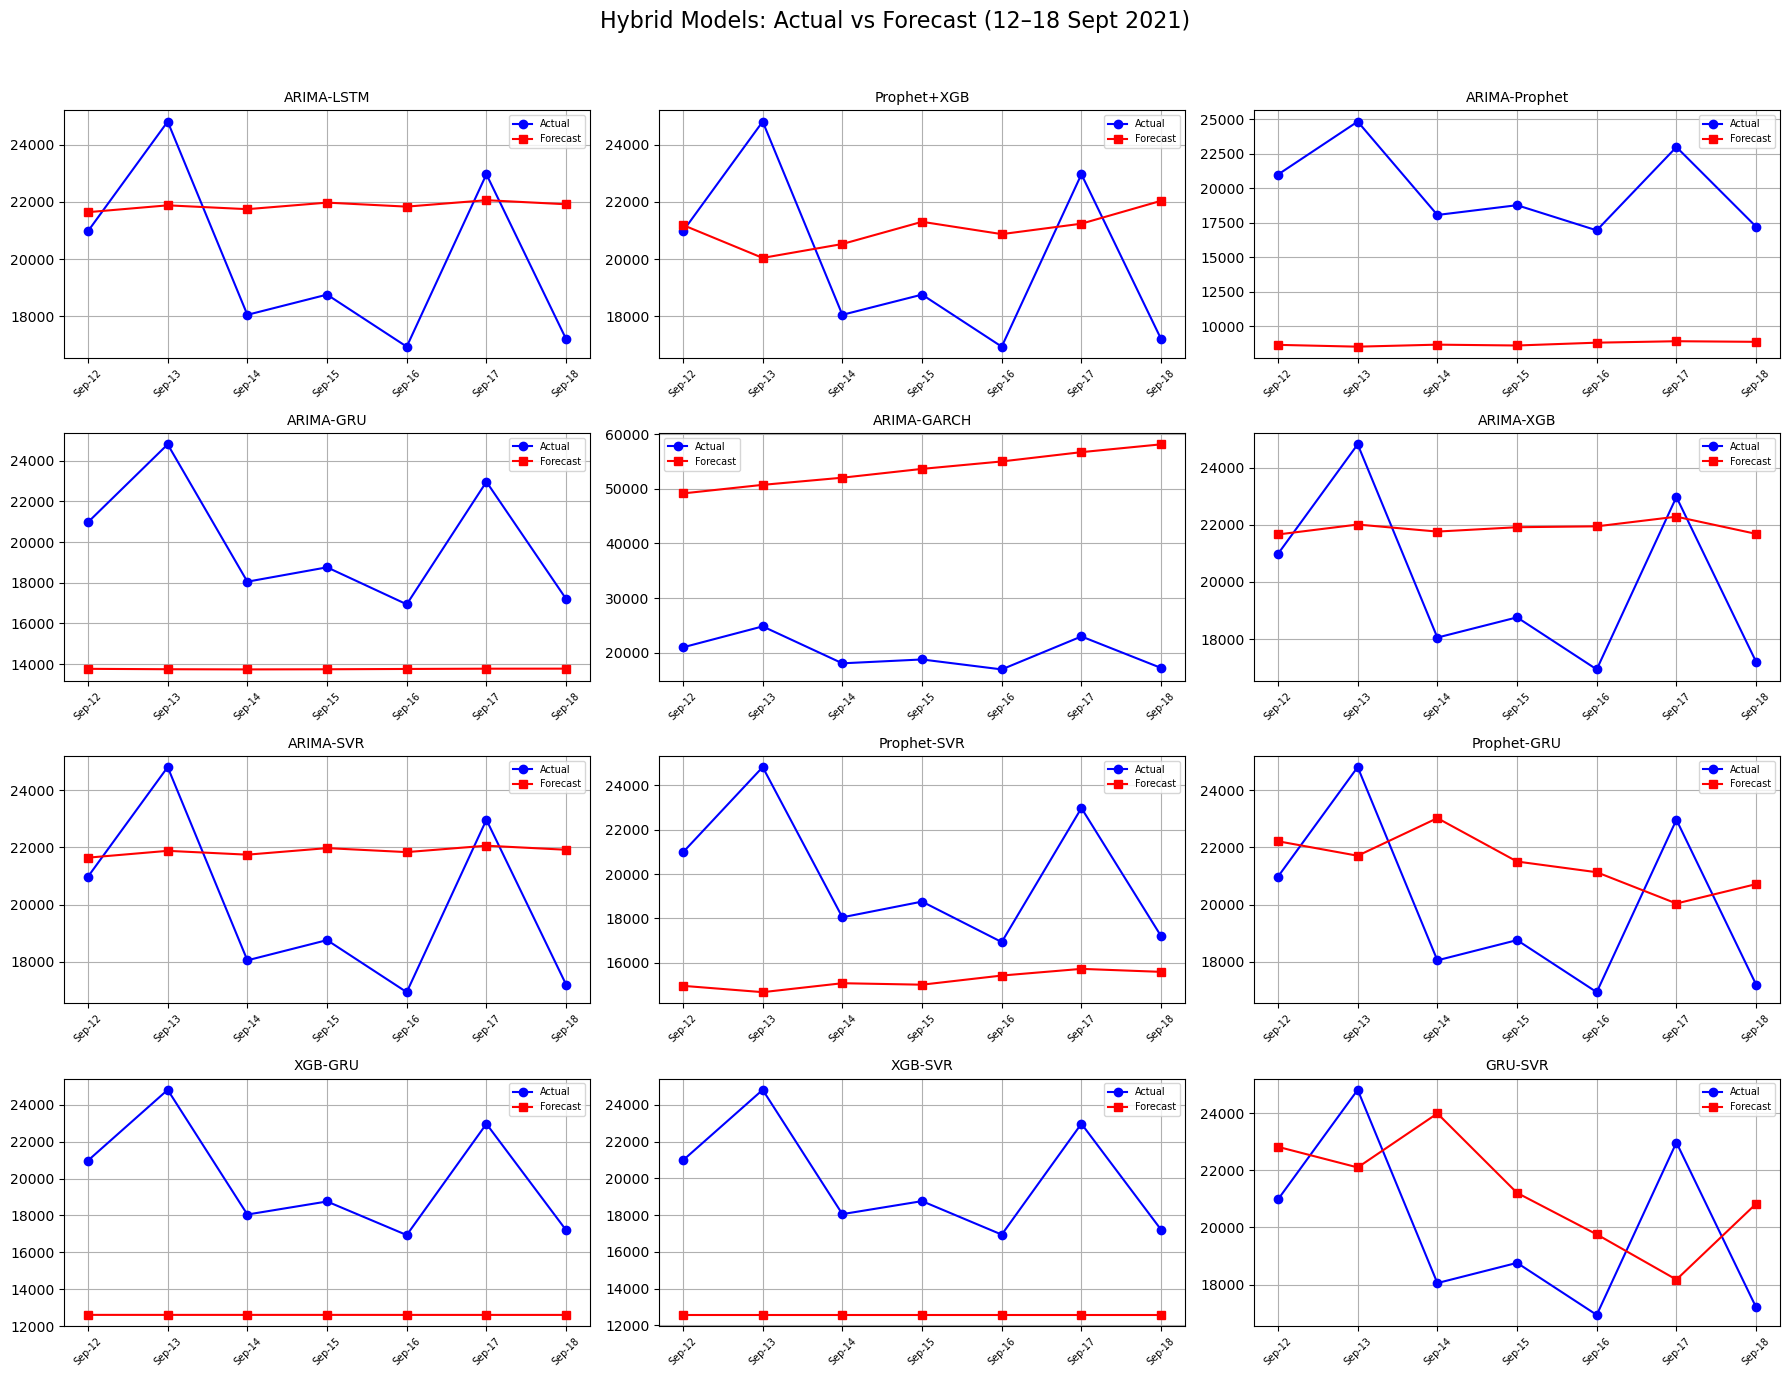

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Create sample DataFrames (replace with your real ones)
# -------------------------------

# ARIMA-LSTM
arima_lstm = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [21644, 21883, 21749, 21978, 21838, 22063, 21921]
})

# Prophet + XGBoost
prophet_xgb = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [21193.59, 20043.80, 20530.31, 21307.50, 20875.96, 21241.18, 22041.63]
})

# ARIMA-Prophet
arima_prophet = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [8649.11, 8518.89, 8664.02, 8603.51, 8807.51, 8912.44, 8868.82]
})

# ARIMA-GRU
arima_gru = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [13763.05, 13743.48, 13734.84, 13741.45, 13757.01, 13770.15, 13772.51]
})

# ARIMA-GARCH
arima_garch = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [49144.64, 50713.84, 52022.25, 53635.26, 54995.97, 56697.50, 58127.34]
})

# ARIMA-XGB
arima_xgb = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [21660.19, 22006.95, 21760.97, 21913.35, 21944.46, 22281.75, 21680.94]
})

# ARIMA-SVR
arima_svr = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [21644.40, 21883.03, 21749.08, 21978.24, 21838.39, 22062.80, 21920.74]
})

# Prophet-SVR
prophet_svr = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [14969.16, 14684.35, 15086.84, 15020.68, 15431.80, 15732.39, 15597.83]
})

# Prophet-GRU
prophet_gru = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [22218.09, 21711.65, 23027.16, 21508.82, 21134.75, 20040.62, 20718.80]
})

# XGB-GRU
xgb_gru = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [12611.61, 12611.08, 12611.23, 12611.33, 12610.18, 12609.82, 12609.92]
})

# XGB-SVR
xgb_svr = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [12571.05, 12571.05, 12571.05, 12571.05, 12571.05, 12571.05, 12571.05]
})

# GRU-SVR
gru_svr = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [22819, 22098, 23987, 21208, 19757, 18174, 20827]
})

# -------------------------------
# Dictionary of hybrid models
# -------------------------------
hybrid_models = {
    "ARIMA-LSTM": arima_lstm,
    "Prophet+XGB": prophet_xgb,
    "ARIMA-Prophet": arima_prophet,
    "ARIMA-GRU": arima_gru,
    "ARIMA-GARCH": arima_garch,
    "ARIMA-XGB": arima_xgb,
    "ARIMA-SVR": arima_svr,
    "Prophet-SVR": prophet_svr,
    "Prophet-GRU": prophet_gru,
    "XGB-GRU": xgb_gru,
    "XGB-SVR": xgb_svr,
    "GRU-SVR": gru_svr
}

# -------------------------------
# 1. Individual plots on single page
# -------------------------------
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Example: 12 models → 4x3 grid
rows, cols = 4, 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 14))
axes = axes.flatten()

# 🔹 Loop through models
for i, (name, df) in enumerate(hybrid_models.items()):
    ax = axes[i]
    ax.plot(df["Date"], df["Actual"], marker="o", label="Actual", color="blue")
    ax.plot(df["Date"], df["Forecast"], marker="s", label="Forecast", color="red")
    
    ax.set_title(name, fontsize=10)
    ax.legend(fontsize=7)
    ax.grid(True)

    # 🔹 Fix x-axis label overlap
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%d"))  # e.g. Sep-12
    ax.tick_params(axis="x", rotation=45, labelsize=7)

# 🔹 Remove unused axes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Hybrid Models: Actual vs Forecast (12–18 Sept 2021)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()




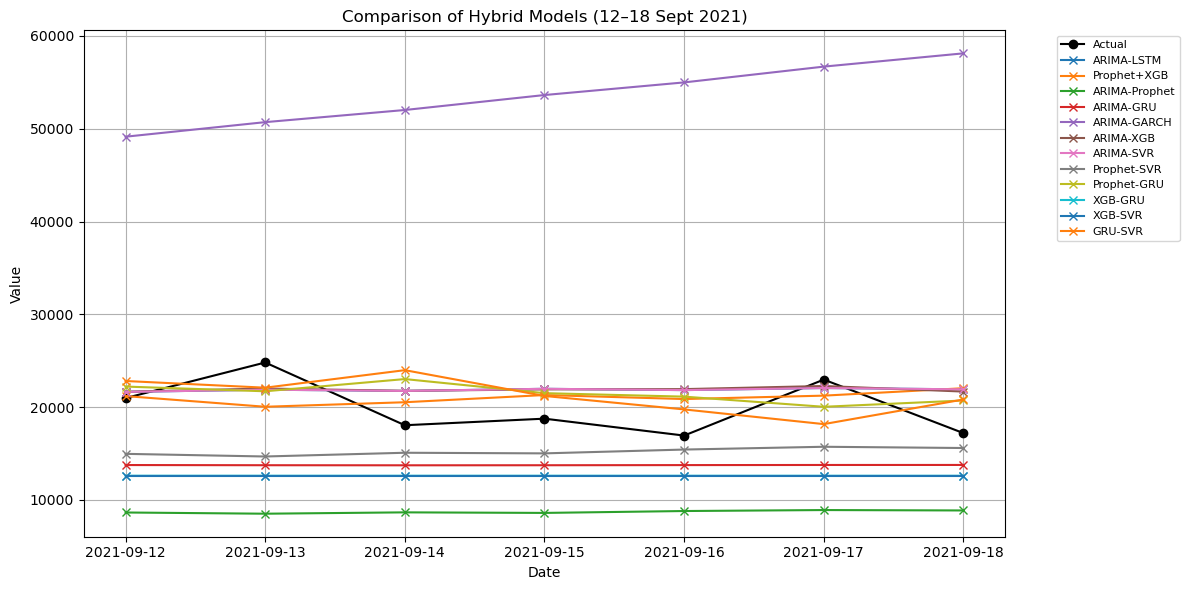

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Create sample DataFrames (replace with your real ones)
# -------------------------------

# ARIMA-LSTM
arima_lstm = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [21644, 21883, 21749, 21978, 21838, 22063, 21921]
})

# Prophet + XGBoost
prophet_xgb = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [21193.59, 20043.80, 20530.31, 21307.50, 20875.96, 21241.18, 22041.63]
})

# ARIMA-Prophet
arima_prophet = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [8649.11, 8518.89, 8664.02, 8603.51, 8807.51, 8912.44, 8868.82]
})

# ARIMA-GRU
arima_gru = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [13763.05, 13743.48, 13734.84, 13741.45, 13757.01, 13770.15, 13772.51]
})

# ARIMA-GARCH
arima_garch = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [49144.64, 50713.84, 52022.25, 53635.26, 54995.97, 56697.50, 58127.34]
})

# ARIMA-XGB
arima_xgb = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [21660.19, 22006.95, 21760.97, 21913.35, 21944.46, 22281.75, 21680.94]
})

# ARIMA-SVR
arima_svr = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [21644.40, 21883.03, 21749.08, 21978.24, 21838.39, 22062.80, 21920.74]
})

# Prophet-SVR
prophet_svr = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [14969.16, 14684.35, 15086.84, 15020.68, 15431.80, 15732.39, 15597.83]
})

# Prophet-GRU
prophet_gru = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [22218.09, 21711.65, 23027.16, 21508.82, 21134.75, 20040.62, 20718.80]
})

# XGB-GRU
xgb_gru = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [12611.61, 12611.08, 12611.23, 12611.33, 12610.18, 12609.82, 12609.92]
})

# XGB-SVR
xgb_svr = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [12571.05, 12571.05, 12571.05, 12571.05, 12571.05, 12571.05, 12571.05]
})

# GRU-SVR
gru_svr = pd.DataFrame({
    "Date": pd.date_range("2021-09-12", "2021-09-18"),
    "Actual": [20980, 24813, 18053, 18760, 16939, 22970, 17205],
    "Forecast": [22819, 22098, 23987, 21208, 19757, 18174, 20827]
})

# -------------------------------
# Dictionary of hybrid models
# -------------------------------
hybrid_models = {
    "ARIMA-LSTM": arima_lstm,
    "Prophet+XGB": prophet_xgb,
    "ARIMA-Prophet": arima_prophet,
    "ARIMA-GRU": arima_gru,
    "ARIMA-GARCH": arima_garch,
    "ARIMA-XGB": arima_xgb,
    "ARIMA-SVR": arima_svr,
    "Prophet-SVR": prophet_svr,
    "Prophet-GRU": prophet_gru,
    "XGB-GRU": xgb_gru,
    "XGB-SVR": xgb_svr,
    "GRU-SVR": gru_svr
}


# -------------------------------
# 2. All models together
# -------------------------------
plt.figure(figsize=(12, 6))
plt.plot(arima_lstm["Date"], arima_lstm["Actual"], marker='o', color='black', label="Actual")

for name, df in hybrid_models.items():
    plt.plot(df["Date"], df["Forecast"], marker='x', label=name)

plt.title("Comparison of Hybrid Models (12–18 Sept 2021)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()
